,ORDER_YEAR,SALES,YOY_GROWTH_%
0,2003,3516979.54,NaN
1,2004,4724162.60,34.324427
2,2005,1791486.71,-62.078217


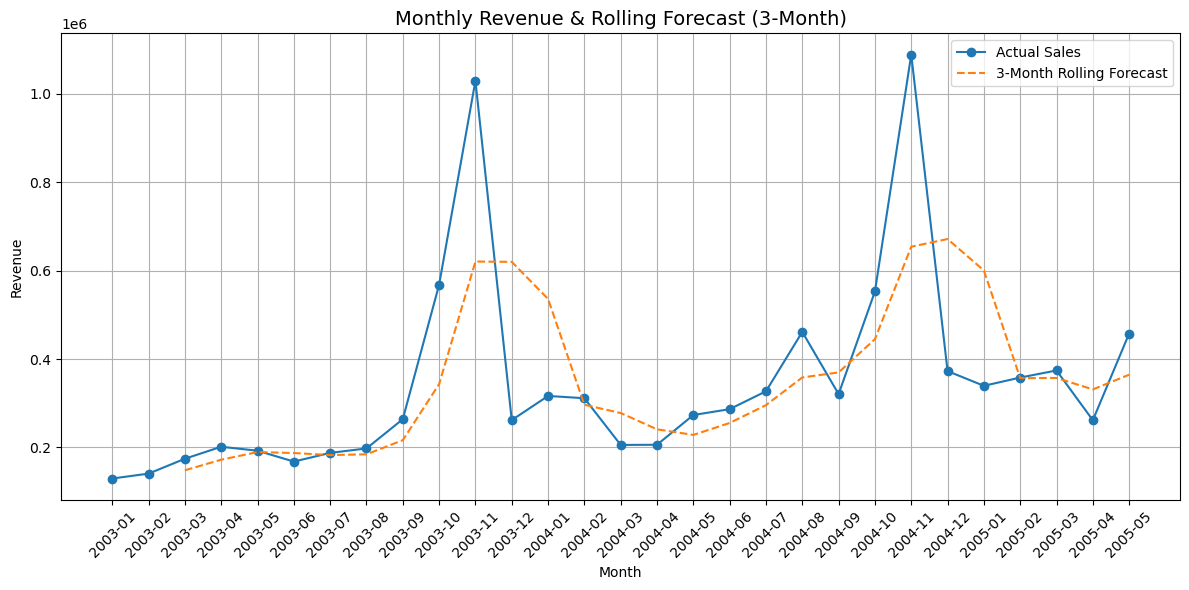

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("sample_data.csv")

# Clean column names
df.columns = [col.strip().upper().replace(" ", "_") for col in df.columns]
df.columns = df.columns.str.replace("ORDERDATE", "ORDER_DATE")

# Parse dates and create time columns
df["ORDER_DATE"] = pd.to_datetime(df["ORDER_DATE"], errors='coerce')
df["ORDER_YEAR"] = df["ORDER_DATE"].dt.year
df["ORDER_MONTH"] = df["ORDER_DATE"].dt.to_period("M")
df["ORDER_DAY"] = df["ORDER_DATE"].dt.date

# YOY revenue summary
yearly_revenue = df.groupby("ORDER_YEAR")["SALES"].sum().reset_index()
yearly_revenue["YOY_GROWTH_%"] = yearly_revenue["SALES"].pct_change() * 100
display(yearly_revenue)

# Monthly revenue with rolling forecast
monthly_revenue = df.groupby("ORDER_MONTH")["SALES"].sum().reset_index()
monthly_revenue["ORDER_MONTH"] = monthly_revenue["ORDER_MONTH"].astype(str)
monthly_revenue["ROLLING_FORECAST"] = monthly_revenue["SALES"].rolling(window=3).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue["ORDER_MONTH"], monthly_revenue["SALES"], marker='o', label="Actual Sales")
plt.plot(monthly_revenue["ORDER_MONTH"], monthly_revenue["ROLLING_FORECAST"], linestyle='--', label="3-Month Rolling Forecast")
plt.xticks(rotation=45)
plt.title("Monthly Revenue & Rolling Forecast (3-Month)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


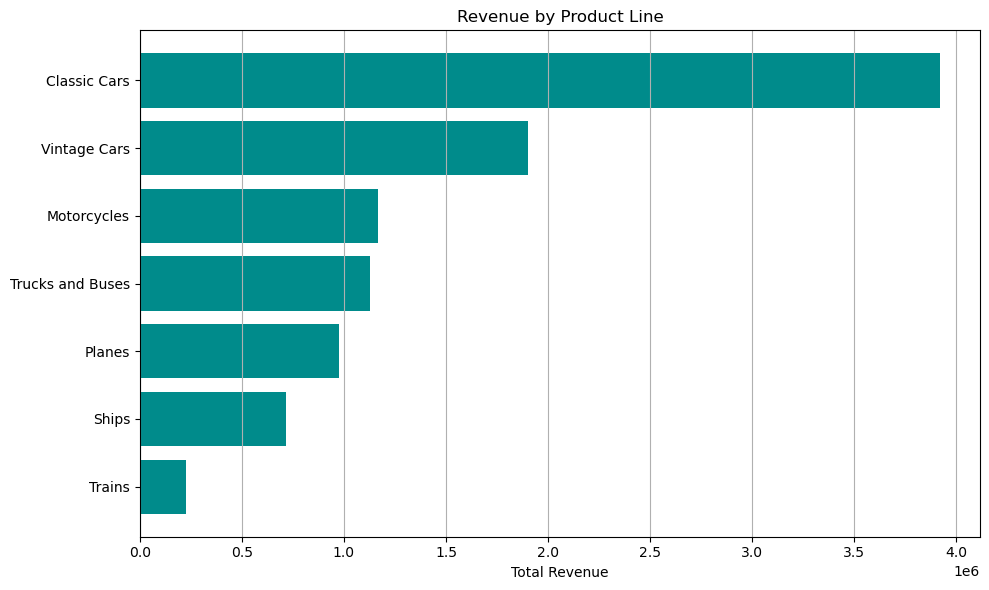

,PRODUCTLINE,TOTAL_REVENUE,AVG_REVENUE,NUM_ORDERS
0,Classic Cars,3919615.66,4053.377104,967
6,Vintage Cars,1903150.84,3135.339110,607
1,Motorcycles,1166388.34,3523.831843,331
5,Trucks and Buses,1127789.84,3746.810100,301
2,Planes,975003.57,3186.286176,306


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("sample_data.csv")

# Clean column names
df.columns = [col.strip().upper().replace(" ", "_") for col in df.columns]
df.columns = df.columns.str.replace("ORDERDATE", "ORDER_DATE")

# Convert order date and extract time info
df["ORDER_DATE"] = pd.to_datetime(df["ORDER_DATE"], errors='coerce')

# 1. Revenue by Product Line
product_line_perf = df.groupby("PRODUCTLINE")["SALES"].agg(["sum", "mean", "count"]).reset_index()
product_line_perf.columns = ["PRODUCTLINE", "TOTAL_REVENUE", "AVG_REVENUE", "NUM_ORDERS"]
product_line_perf = product_line_perf.sort_values(by="TOTAL_REVENUE", ascending=False)

# 2. Revenue and quantity by individual product
product_perf = df.groupby(["PRODUCTCODE", "PRODUCTLINE"]).agg({
    "SALES": "sum",
    "QUANTITYORDERED": "sum",
    "PRICEEACH": "mean"
}).reset_index()
product_perf.columns = ["PRODUCTCODE", "PRODUCTLINE", "TOTAL_REVENUE", "TOTAL_UNITS", "AVG_PRICE"]

# 3. Plot: Revenue by Product Line
plt.figure(figsize=(10, 6))
plt.barh(product_line_perf["PRODUCTLINE"], product_line_perf["TOTAL_REVENUE"], color='darkcyan')
plt.xlabel("Total Revenue")
plt.title("Revenue by Product Line")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 4. Show product line summary
product_line_perf.head()


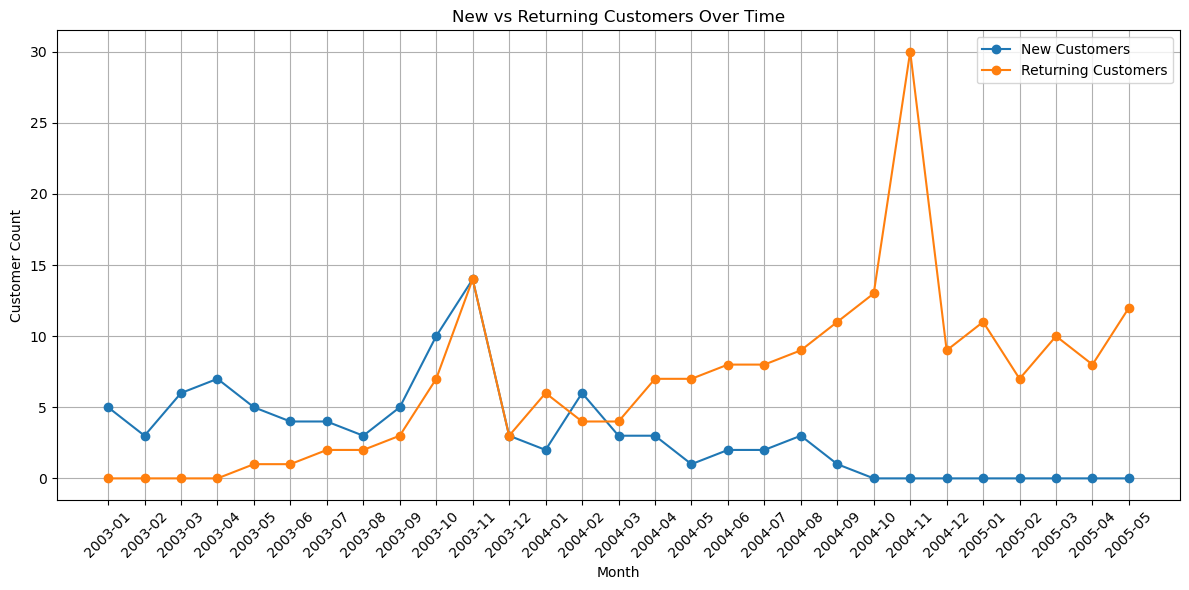

CUSTOMER_TYPE,ORDER_MONTH,new,returning
0,2003-01,5.0,0.0
1,2003-02,3.0,0.0
2,2003-03,6.0,0.0
3,2003-04,7.0,0.0
4,2003-05,5.0,1.0


In [6]:
# Customer Growth & Retention

# 1. First order date per customer
first_orders = df.groupby("CUSTOMERNAME")["ORDER_DATE"].min().reset_index()
first_orders.columns = ["CUSTOMERNAME", "FIRST_ORDER_DATE"]

# 2. Tag each order as "new" or "returning"
df_tagged = df.merge(first_orders, on="CUSTOMERNAME")
df_tagged["CUSTOMER_TYPE"] = df_tagged.apply(
    lambda row: "new" if row["ORDER_DATE"] == row["FIRST_ORDER_DATE"] else "returning",
    axis=1
)

# 3. Monthly counts by type
df_tagged["ORDER_MONTH"] = df_tagged["ORDER_DATE"].dt.to_period("M").astype(str)
customer_trend = (
    df_tagged.groupby(["ORDER_MONTH", "CUSTOMER_TYPE"])["CUSTOMERNAME"]
    .nunique()
    .reset_index()
    .pivot(index="ORDER_MONTH", columns="CUSTOMER_TYPE", values="CUSTOMERNAME")
    .fillna(0)
    .reset_index()
)

# 4. Plot new vs returning customers
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(customer_trend["ORDER_MONTH"], customer_trend.get("new", 0), marker='o', label="New Customers")
plt.plot(customer_trend["ORDER_MONTH"], customer_trend.get("returning", 0), marker='o', label="Returning Customers")
plt.title("New vs Returning Customers Over Time")
plt.xlabel("Month")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Display raw table
customer_trend.head()



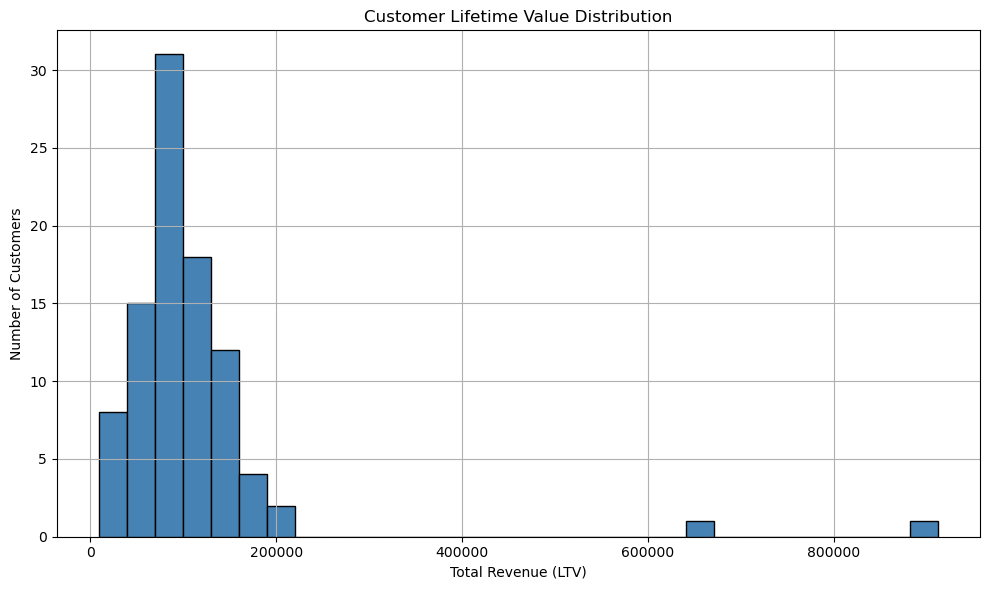

Average LTV by Deal Size:
 DEALSIZE
Large     164963.419167
Small     107313.890000
Medium     85062.294909
Name: TOTAL_REVENUE, dtype: float64

Top 5 Countries by Average LTV:
 COUNTRY
Spain        243137.384000
Singapore    144244.205000
Australia    126124.620000
Italy        124891.436667
Denmark      122818.575000
Name: TOTAL_REVENUE, dtype: float64


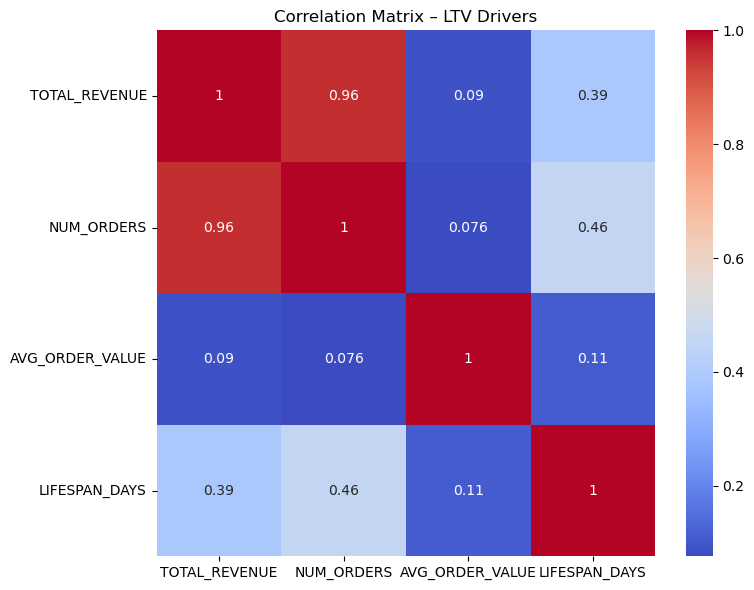

In [7]:
# Customer LTV Segmentation

# 1. Calculate LTV metrics per customer
ltv_df = df.groupby("CUSTOMERNAME").agg(
    TOTAL_REVENUE=("SALES", "sum"),
    NUM_ORDERS=("ORDERNUMBER", "nunique"),
    AVG_ORDER_VALUE=("SALES", "mean"),
    FIRST_ORDER=("ORDER_DATE", "min"),
    LAST_ORDER=("ORDER_DATE", "max")
).reset_index()

ltv_df["LIFESPAN_DAYS"] = (ltv_df["LAST_ORDER"] - ltv_df["FIRST_ORDER"]).dt.days

# 2. Merge with customer metadata
customer_meta = df.groupby("CUSTOMERNAME").agg(
    COUNTRY=("COUNTRY", "first"),
    DEALSIZE=("DEALSIZE", "first")
).reset_index()

ltv_df = ltv_df.merge(customer_meta, on="CUSTOMERNAME")

# 3. Plot LTV distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(ltv_df["TOTAL_REVENUE"], bins=30, color='steelblue', edgecolor='black')
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("Total Revenue (LTV)")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Compare LTV by Deal Size
deal_ltv = ltv_df.groupby("DEALSIZE")["TOTAL_REVENUE"].mean().sort_values(ascending=False)
print("Average LTV by Deal Size:\n", deal_ltv)

# 5. Compare LTV by Country (top 5 only)
country_ltv = ltv_df.groupby("COUNTRY")["TOTAL_REVENUE"].mean().sort_values(ascending=False).head(5)
print("\nTop 5 Countries by Average LTV:\n", country_ltv)

# 6. Correlation matrix for numeric LTV drivers
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(ltv_df[["TOTAL_REVENUE", "NUM_ORDERS", "AVG_ORDER_VALUE", "LIFESPAN_DAYS"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix – LTV Drivers")
plt.tight_layout()
plt.show()


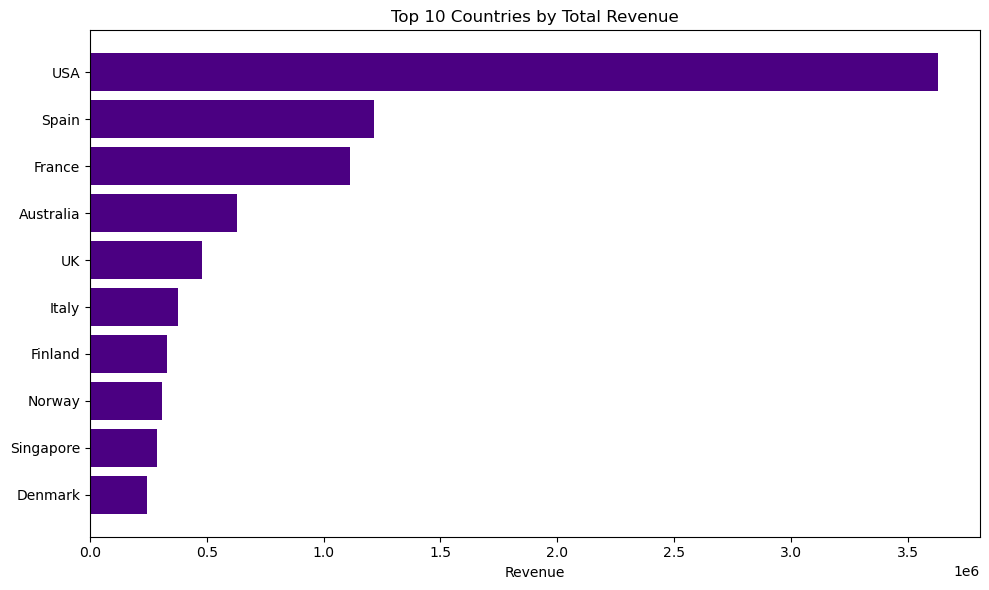

(     COUNTRY  TOTAL_REVENUE  NUM_CUSTOMERS  AVG_ORDER_VALUE
 0        USA     3627982.83             35      3613.528715
 1      Spain     1215686.92              5      3554.640117
 2     France     1110916.52             12      3537.950701
 3  Australia      630623.10              5      3408.773514
 4         UK      478880.46              5      3325.558750,
   DEALSIZE  TOTAL_REVENUE  AVG_ORDER_VALUE  NUM_ORDERS
 1   Medium     6087432.24      4398.433699        1384
 2    Small     2643077.35      2061.682800        1282
 0    Large     1302119.26      8293.753248         157,
 Empty DataFrame
 Columns: [PRODUCTCODE, TOTAL_REVENUE, AVG_MSRP, TOTAL_UNITS]
 Index: [])

In [8]:
# Segment-Level Recommendations

# 1. Revenue by Country
country_summary = df.groupby("COUNTRY").agg(
    TOTAL_REVENUE=("SALES", "sum"),
    NUM_CUSTOMERS=("CUSTOMERNAME", "nunique"),
    AVG_ORDER_VALUE=("SALES", "mean")
).sort_values(by="TOTAL_REVENUE", ascending=False).reset_index()

# Plot top 10 countries by revenue
top_countries = country_summary.head(10)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_countries["COUNTRY"], top_countries["TOTAL_REVENUE"], color="indigo")
plt.title("Top 10 Countries by Total Revenue")
plt.xlabel("Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Revenue by Deal Size
deal_summary = df.groupby("DEALSIZE")["SALES"].agg(["sum", "mean", "count"]).reset_index()
deal_summary.columns = ["DEALSIZE", "TOTAL_REVENUE", "AVG_ORDER_VALUE", "NUM_ORDERS"]
deal_summary = deal_summary.sort_values(by="TOTAL_REVENUE", ascending=False)

# 3. Underperforming Products (low revenue, high MSRP)
product_flag = df.groupby("PRODUCTCODE").agg(
    TOTAL_REVENUE=("SALES", "sum"),
    AVG_MSRP=("MSRP", "mean"),
    TOTAL_UNITS=("QUANTITYORDERED", "sum")
).reset_index()

underperformers = product_flag[(product_flag["TOTAL_REVENUE"] < 1000) & (product_flag["AVG_MSRP"] > 80)]
underperformers = underperformers.sort_values(by="AVG_MSRP", ascending=False)

# Show recommendations
country_summary.head(), deal_summary, underperformers.head()


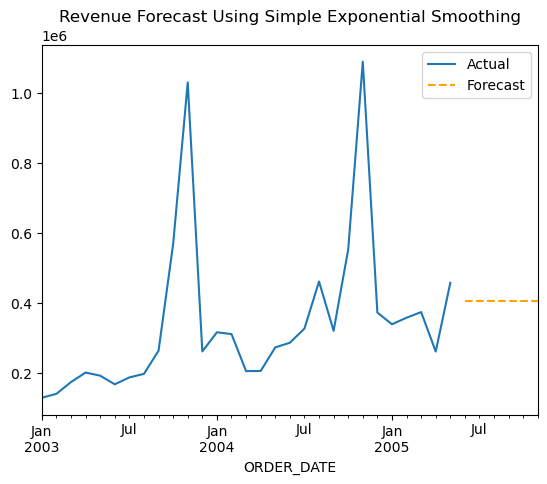

In [9]:
# Forecasting Model

from statsmodels.tsa.api import SimpleExpSmoothing

monthly_sales = df.groupby("ORDER_DATE")["SALES"].sum().resample("ME").sum()

model = SimpleExpSmoothing(monthly_sales).fit(smoothing_level=0.2, optimized=False)
forecast = model.forecast(6)  # Forecast next 6 months

monthly_sales.plot(label="Actual")
forecast.plot(label="Forecast", linestyle="--", color="orange")
plt.title("Revenue Forecast Using Simple Exponential Smoothing")
plt.legend()
plt.show()


In [10]:
# Feature Engineering for LTV Segmentation

from datetime import timedelta

# 1. Order-level aggregation
orders_per_customer = df.groupby("CUSTOMERNAME").agg(
    FIRST_ORDER=("ORDER_DATE", "min"),
    LAST_ORDER=("ORDER_DATE", "max"),
    TOTAL_REVENUE=("SALES", "sum"),
    NUM_ORDERS=("ORDERNUMBER", "nunique")
).reset_index()

orders_per_customer["LIFESPAN_DAYS"] = (orders_per_customer["LAST_ORDER"] - orders_per_customer["FIRST_ORDER"]).dt.days
orders_per_customer["LIFESPAN_DAYS"] = orders_per_customer["LIFESPAN_DAYS"].replace(0, 1)  # Avoid divide-by-zero

# 2. Order frequency and revenue per day
orders_per_customer["ORDER_FREQUENCY"] = orders_per_customer["NUM_ORDERS"] / orders_per_customer["LIFESPAN_DAYS"]
orders_per_customer["REVENUE_PER_DAY"] = orders_per_customer["TOTAL_REVENUE"] / orders_per_customer["LIFESPAN_DAYS"]

# 3. Days between orders (avg)
avg_days_df = df.groupby("CUSTOMERNAME").agg(
    ORDER_DATES=("ORDER_DATE", lambda x: list(sorted(x)))
).reset_index()

def avg_days_between(dates):
    if len(dates) < 2:
        return None
    deltas = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
    return sum(deltas) / len(deltas)

avg_days_df["AVG_DAYS_BETWEEN_ORDERS"] = avg_days_df["ORDER_DATES"].apply(avg_days_between)
avg_days_df.drop(columns=["ORDER_DATES"], inplace=True)

# 4. Repeat purchase rate
repeat_df = df.groupby("CUSTOMERNAME").agg(
    TOTAL_ORDER_LINES=("ORDERNUMBER", "count"),
    DISTINCT_ORDERS=("ORDERNUMBER", "nunique")
).reset_index()

repeat_df["REPEAT_RATE"] = (repeat_df["TOTAL_ORDER_LINES"] - repeat_df["DISTINCT_ORDERS"]) / repeat_df["TOTAL_ORDER_LINES"]

# 5. Merge everything
features_df = orders_per_customer.merge(avg_days_df, on="CUSTOMERNAME", how="left")
features_df = features_df.merge(repeat_df[["CUSTOMERNAME", "REPEAT_RATE"]], on="CUSTOMERNAME", how="left")

# Display top engineered features
features_df[["CUSTOMERNAME", "TOTAL_REVENUE", "NUM_ORDERS", "ORDER_FREQUENCY", 
             "REVENUE_PER_DAY", "AVG_DAYS_BETWEEN_ORDERS", "REPEAT_RATE"]].head()


,CUSTOMERNAME,TOTAL_REVENUE,NUM_ORDERS,ORDER_FREQUENCY,REVENUE_PER_DAY,AVG_DAYS_BETWEEN_ORDERS,REPEAT_RATE
0,"AV Stores, Co.",157807.81,3,0.004918,258.701328,12.200000,0.941176
1,Alpha Cognac,70488.44,3,0.004739,111.356145,33.315789,0.850000
2,Amica Models & Co.,94117.26,2,0.086957,4092.054783,0.920000,0.923077
3,"Anna's Decorations, Ltd",153996.13,4,0.007339,282.561706,12.111111,0.913043
4,Atelier graphique,24179.96,3,0.005405,43.567495,92.500000,0.571429
